In [1]:
# baseline


import zipfile
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import scipy as sp

def logloss(act, pred):
  epsilon = 1e-15
  pred = sp.maximum(epsilon, pred)
  pred = sp.minimum(1-epsilon, pred)
  ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
  ll = ll * -1.0/len(act)
  return ll
# load data
data_root = "."
dfTrain = pd.read_csv("%s/train.csv"%data_root)
dfTest = pd.read_csv("%s/test.csv"%data_root)
dfAd = pd.read_csv("%s/ad.csv"%data_root)

# process data
dfTrain = pd.merge(dfTrain, dfAd, on="creativeID")
dfTest = pd.merge(dfTest, dfAd, on="creativeID")
dfTrain = dfTrain.drop('conversionTime', 1)
dfTrain = dfTrain.drop('clickTime', 1)
dfTrain = dfTrain.dropna(axis=0, how='any')
y = dfTrain['label']
dfTrain = dfTrain.drop('label', 1)
     
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfTrain, y, test_size=0.1, random_state=0)
# model training
lr = LogisticRegression()
lr.fit(X_train, y_train)
pre_train = lr.predict_proba(X_train)[:,1]
pre_test = lr.predict_proba(X_test)[:,1]

print logloss(y_train,pre_train)
print logloss(y_test,pre_test)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.123658523946
0.12320703242


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# load data
data_root = "."
dfTrain = pd.read_csv("%s/train.csv"%data_root)
dfAd = pd.read_csv("%s/ad.csv"%data_root)
dfPosition = pd.read_csv("%s/position.csv"%data_root)
dfCategory = pd.read_csv("%s/app_categories.csv"%data_root)
dfUser = pd.read_csv("%s/user.csv"%data_root)
# process data
dfTrain = pd.merge(dfTrain, dfAd, on="creativeID")
dfTrain = pd.merge(dfTrain, dfUser, on="userID")
dfTrain = pd.merge(dfTrain, dfPosition, on="positionID")
dfTrain = pd.merge(dfTrain, dfCategory, on="appID")

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Temporal features
dfTrain['clickTime_day'] = dfTrain['clickTime'].map(lambda x:int(x/10000))
dfTrain['clickTime_hour'] = dfTrain['clickTime'].map(lambda x:int(x/100%100))
dfTrain['clickTime_minute'] = dfTrain['clickTime'].map(lambda x:int(x%100))

#Click count feature
dfCount = dfTrain.groupby('userID').size().reset_index(name='click_count')
dfTrain = pd.merge(dfTrain, dfCount, on="userID")

In [3]:
#Fill missing data
dfTrain['age'] = dfTrain['age'].replace(0,np.nan)
dfTrain['residence'] = dfTrain['residence'].replace(0,np.nan)
dfTrain['hometown'] = dfTrain['hometown'].replace(0,np.nan)
dfTrain = dfTrain.interpolate(method = 'values')
print dfTrain.head()


   label  clickTime  conversionTime  creativeID   userID  positionID  \
0      0     170000             NaN        3089  2798058         293   
1      0     180028             NaN        3089  1683269         293   
2      0     191045             NaN        3089   240899         293   
3      0     202250             NaN        5970  2270688         293   
4      0     201637             NaN        2524  2270688        2720   

   connectionType  telecomsOperator  adID  camgaignID     ...       haveBaby  \
0               1                 1  1321          83     ...              1   
1               2                 3  1321          83     ...              0   
2               1                 2  1321          83     ...              0   
3               1                 2   612          83     ...              0   
4               1                 2   134          83     ...              0   

   hometown  residence  sitesetID  positionType  appCategory  clickTime_day  \
0      

In [4]:
# Drop missing data
dfTrain = dfTrain.drop('conversionTime', 1)
dfTrain = dfTrain.drop('clickTime', 1)
dfTrain = dfTrain.dropna(axis=0, how='any')
y = dfTrain['label']
dfTrain = dfTrain.drop('label', 1)
print dfTrain.head()
#X_train = dfTrain

   creativeID   userID  positionID  connectionType  telecomsOperator  adID  \
1        3089  1683269         293               2                 3  1321   
2        3089   240899         293               1                 2  1321   
3        5970  2270688         293               1                 2   612   
4        2524  2270688        2720               1                 2   134   
5         225  2270688        6995               1                 2  1977   

   camgaignID  advertiserID  appID  appPlatform     ...       haveBaby  \
1          83            10    434            1     ...              0   
2          83            10    434            1     ...              0   
3          83            10    434            1     ...              0   
4          83            10    434            1     ...              0   
5          83            10    434            1     ...              0   

   hometown  residence  sitesetID  positionType  appCategory  clickTime_day  \
1    21

In [5]:
# one-hot encoding
feats = ['connectionType','telecomsOperator',"appPlatform",'gender','education','marriageStatus','haveBaby','positionType','appCategory']
Xtrain = pd.get_dummies(dfTrain,columns = feats,sparse=True)
print Xtrain.shape

(3749527, 68)


In [6]:
# normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns)
print Xtrain_scaled.head()

   creativeID    userID  positionID      adID  camgaignID  advertiserID  \
0    0.469230  0.600071    0.038200  0.365145    0.114047           0.1   
1    0.469230  0.085878    0.038200  0.365145    0.114047           0.1   
2    0.907005  0.809480    0.038200  0.169018    0.114047           0.1   
3    0.383376  0.809480    0.355704  0.036791    0.114047           0.1   
4    0.034037  0.809480    0.914966  0.546611    0.114047           0.1   

      appID       age  hometown  residence       ...         appCategory_106  \
0  0.917031  0.240506  0.608485   0.364435       ...                     0.0   
1  0.917031  0.227848  0.364242   0.273856       ...                     0.0   
2  0.917031  0.240506  0.364121   0.364435       ...                     0.0   
3  0.917031  0.240506  0.364000   0.364435       ...                     0.0   
4  0.917031  0.240506  0.363879   0.364435       ...                     0.0   

   appCategory_108  appCategory_201  appCategory_203  appCategory_20

In [7]:
# cross-validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_scaled, y, test_size=0.1, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3374574, 68)
(374953, 68)
(3374574,)
(374953,)


In [8]:
# logloss function
import scipy as sp
import numpy as np
def logloss(act, pred):
  epsilon = 1e-15
  pred = sp.maximum(epsilon, pred)
  pred = sp.minimum(1-epsilon, pred)
  ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
  ll = ll * -1.0/len(act)
  return ll

In [11]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
clf_train = clf.predict_proba(X_train)[:,1]
clf_test = clf.predict_proba(X_test)[:,1]

print logloss(y_train,clf_train)
print logloss(y_test,clf_test)

0.0211584545087
0.252509803951


In [13]:
#feature importance
importances = clf.feature_importances_
importance = pd.DataFrame(importances, index=X_train.columns, 
                          columns=["importance"])
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
importance = importance.sort_values(by='importance', ascending=False)
indices =  importance.index.tolist()
importance = np.reshape(importance.values,-1)
print indices
print importance

['userID', 'hometown', 'clickTime_minute', 'residence', 'age', 'clickTime_hour', 'clickTime_day', 'positionID', 'creativeID', 'adID', 'click_count', 'camgaignID', 'telecomsOperator_1', 'telecomsOperator_3', 'marriageStatus_0', 'education_1', 'telecomsOperator_2', 'education_3', 'education_2', 'marriageStatus_1', 'education_0', 'marriageStatus_2', 'haveBaby_0', 'advertiserID', 'education_4', 'haveBaby_1', 'appCategory_407', 'education_5', 'marriageStatus_3', 'appID', 'gender_1', 'gender_2', 'telecomsOperator_0', 'gender_0', 'sitesetID', 'haveBaby_2', 'connectionType_1', 'positionType_0', 'education_6', 'haveBaby_3', 'haveBaby_4', 'positionType_1', 'haveBaby_5', 'connectionType_2', 'appCategory_402', 'education_7', 'haveBaby_6', 'positionType_5', 'appCategory_104', 'positionType_3', 'appPlatform_2', 'appPlatform_1', 'appCategory_201', 'appCategory_2', 'positionType_2', 'appCategory_209', 'appCategory_203', 'connectionType_3', 'appCategory_108', 'appCategory_503', 'connectionType_4', 'con

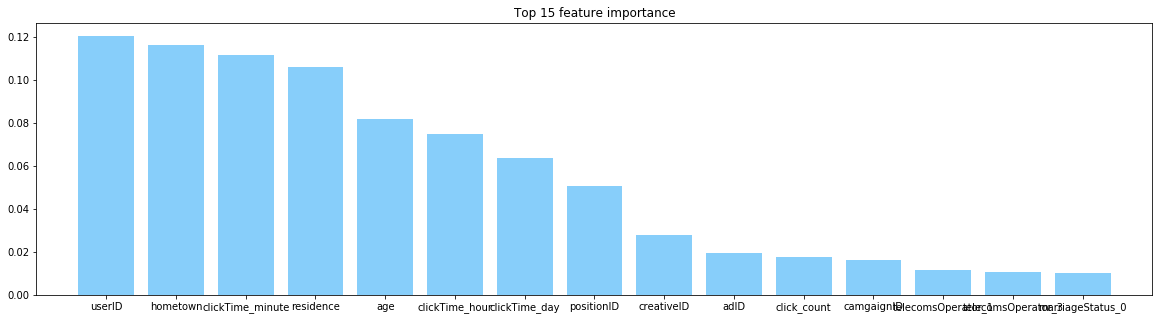

In [14]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,5))
plt.title("Top 15 feature importance")
plt.bar(range(15),importance[0:15],
       color='lightskyblue', align="center")
plt.xticks(range(15), indices[0:15])
plt.rc('xtick', labelsize=10)
plt.xlim([-1, 15])
plt.savefig('20.jpg')
plt.show()


In [15]:
import xgboost as xgb
xlf = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic')

xlf.fit(X_train, y_train, eval_metric='rmse', eval_set = [(X_test,y_test)],verbose = True, early_stopping_rounds=2)

[0]	validation_0-rmse:0.455058
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.41536
[2]	validation_0-rmse:0.380283
[3]	validation_0-rmse:0.34932
[4]	validation_0-rmse:0.322023
[5]	validation_0-rmse:0.297994
[6]	validation_0-rmse:0.276932
[7]	validation_0-rmse:0.258526
[8]	validation_0-rmse:0.242499
[9]	validation_0-rmse:0.228615
[10]	validation_0-rmse:0.216643
[11]	validation_0-rmse:0.206343
[12]	validation_0-rmse:0.197539
[13]	validation_0-rmse:0.190054
[14]	validation_0-rmse:0.183711
[15]	validation_0-rmse:0.178355
[16]	validation_0-rmse:0.173869
[17]	validation_0-rmse:0.170108
[18]	validation_0-rmse:0.166977
[19]	validation_0-rmse:0.164369
[20]	validation_0-rmse:0.162201
[21]	validation_0-rmse:0.16041
[22]	validation_0-rmse:0.158927
[23]	validation_0-rmse:0.157709
[24]	validation_0-rmse:0.156715
[25]	validation_0-rmse:0.155887
[26]	validation_0-rmse:0.155193
[27]	validation_0-rmse:0.154641
[28]	validation_0-rmse:0.15419
[29]	validation_0-rmse

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [16]:
xlf_train = xlf.predict(X_train)
xlf_test = xlf.predict(X_test)

print logloss(y_train,xlf_train)
print logloss(y_test,xlf_test)

0.100714245239
0.0999417426064


In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_train = lr.predict_proba(X_train)[:,1]
lr_test = lr.predict_proba(X_test)[:,1]

print logloss(y_train,lr_train)
print logloss(y_test,lr_test)

0.107118789376
0.105843664257


In [76]:
#ensemble
pred_train = np.transpose(np.vstack((lr_train,clf_train,xlf_train)))
pred_test = np.transpose(np.vstack((lr_test,clf_test, xlf_test)))

#pred_train = np.transpose(np.vstack((lr_train,xlf_train)))
#pred_test = np.transpose(np.vstack((lr_test,xlf_test)))
#lr.fit(pred_train, y_train)
xlf = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=800,
    max_depth=1,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic')
xlf.fit(pred_train, y_train, eval_metric='rmse', eval_set = [(pred_test,y_test)],verbose = True, early_stopping_rounds=5)


[0]	validation_0-rmse:0.453209
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.411995
[2]	validation_0-rmse:0.375706
[3]	validation_0-rmse:0.343837
[4]	validation_0-rmse:0.315842
[5]	validation_0-rmse:0.291432
[6]	validation_0-rmse:0.270216
[7]	validation_0-rmse:0.251764
[8]	validation_0-rmse:0.235883
[9]	validation_0-rmse:0.222396
[10]	validation_0-rmse:0.210979
[11]	validation_0-rmse:0.201245
[12]	validation_0-rmse:0.193243
[13]	validation_0-rmse:0.186484
[14]	validation_0-rmse:0.181064
[15]	validation_0-rmse:0.176529
[16]	validation_0-rmse:0.172991
[17]	validation_0-rmse:0.170027
[18]	validation_0-rmse:0.167807
[19]	validation_0-rmse:0.1661
[20]	validation_0-rmse:0.164626
[21]	validation_0-rmse:0.163637
[22]	validation_0-rmse:0.162755
[23]	validation_0-rmse:0.162236
[24]	validation_0-rmse:0.161889
[25]	validation_0-rmse:0.161526
[26]	validation_0-rmse:0.161407
[27]	validation_0-rmse:0.161369
[28]	validation_0-rmse:0.161233
[29]	validation_0-r

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=800, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [77]:
xlf_train = xlf.predict(pred_train)
xlf_test = xlf.predict(pred_test)
print xlf_train.max()
#lr_train = lr.predict_proba(pred_train)[:,1]
#lr_test = lr.predict_proba(pred_test)[:,1]
print logloss(y_train,xlf_train)
print logloss(y_test,xlf_test)

0.98013
0.0118098463243
0.129881999324
